In [16]:
import os
import sys
import glob
import math
from pathlib import Path

import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
torch.backends.cudnn.benchmark = True

from dblock import results

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
root = Path(os.path.abspath("")).parent.parent

In [19]:
benchmark_dvst_query = results.dBenchmarkdvstQuery(os.path.join(root, "results/benchmarks/dvst"))
benchmark_dvsn_query = results.dBenchmarkdvsnQuery(os.path.join(root, "results/benchmarks/dvsn"))
palette = [sns.color_palette("light:b", as_cmap=False)[i] for i in [1, 3, 5]]

In [21]:
beta_requires_grad=True

# 1. Robust speedup

## 2D speedup plot

In [22]:
class MidpointNormalize(matplotlib.colors.Normalize):
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)
    
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [24]:
def plot_contour(ax, x, y, z, z_min, z_max, fontscale=1, ylabel=None, title="", s=3, cmap=plt.cm.RdBu, midpoint=0):
    title_size = int(fontscale * 20)
    labelsize = int(fontscale * 20)
    ticksize = int(fontscale * 14)
    tickpad = int(fontscale * 10)
    labelpad = int(fontscale * 16)
    titlepad = int(fontscale * 15)
    edge_width = 0
    
    colorbar = ax.tricontourf(x, y, z, levels=np.linspace(z_min, z_max, 100), cmap=cmap, norm=MidpointNormalize(midpoint=midpoint))
    ax.scatter(x, y, c="gray", s=s)
    
    ax.spines["bottom"].set_linewidth(edge_width)
    ax.spines["top"].set_linewidth(edge_width)
    ax.spines["left"].set_linewidth(edge_width)
    ax.spines["right"].set_linewidth(edge_width)
    ax.xaxis.set_tick_params(width=edge_width)
    ax.yaxis.set_tick_params(width=edge_width)
    
    x_labels = [f"{int(v)}" for v in pd.Series(x).unique()]
    ax.set_yticks(list(pd.Series(y).unique()))
    ax.set_xticks(list(pd.Series(x).unique()))
    ax.set_xticklabels(x_labels)
    
    y_labels = [f"${v}$" for v in pd.Series(y).unique()]
    ax.set_yticklabels(y_labels)
    
    ax.tick_params(axis='both', which='major', labelsize=ticksize, pad=tickpad)
    
    # Title
    ax.set_title(title, fontsize=title_size, pad=titlepad)
    
    return colorbar

In [26]:
def plot_2d_speedups(fig, spec, speedups_df, x_label, y_label, title, log_x=True, cmap=plt.cm.RdBu, midpoint=0):
    multi_index = speedups_df.index
    x = [np.log2(index[0]) if log_x else index[0] for index in multi_index]
    y = [index[2] for index in multi_index]
    total_speedups = np.log2(speedups_df["total_speedup"])
    
    acc_z_min = total_speedups.min()
    acc_z_max = total_speedups.max()
    c = max(abs(acc_z_min), acc_z_max)
    
    speedup_rigt_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec, wspace=0.1, hspace=0.3, width_ratios=[0.95, 0.03])
    
    # Plot data
    ax = plt.Subplot(fig, speedup_rigt_spec[0])
    fig.add_subplot(ax)
    colorbar = plot_contour(ax, x, y, total_speedups, acc_z_min, acc_z_max, ylabel=y_label, title=title, s=15, cmap=cmap, midpoint=midpoint)
    
    label_size = 20
    ax.set_ylabel(y_label, fontsize=label_size, labelpad=15)
    ax.set_xlabel(x_label, fontsize=label_size, labelpad=15)
    
    # Plot colorbar
    cbar_ax = plt.Subplot(fig, speedup_rigt_spec[1])
    fig.add_subplot(cbar_ax)
    cbar = fig.colorbar(colorbar, cbar_ax)
    
    cbarsize = 16
    cbarticksize = 16 #10
    cbartitle = "Speedup $\\times$"
    cbar = fig.colorbar(colorbar, cbar_ax)
    
    show_lower = False
    show_upper = False
    ticks = list(range(math.ceil(acc_z_min) + (0 if show_lower else 1), math.floor(acc_z_max) + (1 if show_upper else 0)))
    ticks = [acc_z_min, *ticks, acc_z_max]

    tick_labels = [2 ** e for e in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{v:0.2f}$\\times$' for v in tick_labels])
    cbar.ax.get_yaxis().labelpad = 10
    # cbar.ax.set_ylabel(cbartitle, fontsize=cbarsize)
    cbar.ax.tick_params(labelsize=cbarticksize)

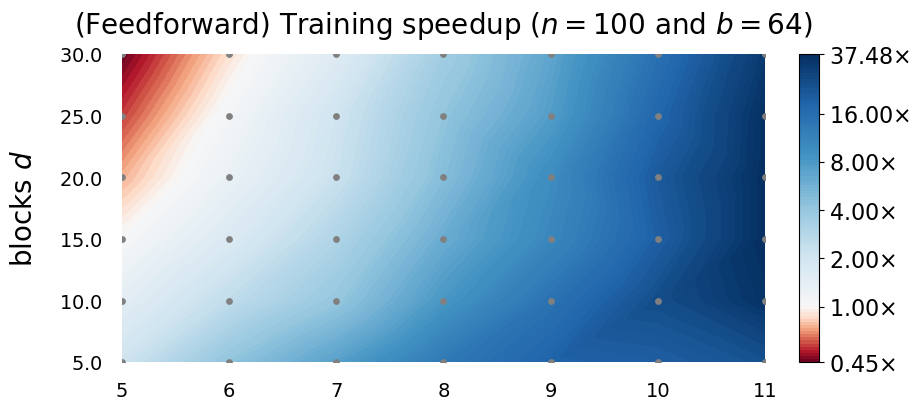

In [28]:
def plot_feedforward_dvst(fig, spec):
    batch = 64
    speedups_df = benchmark_dvst_query.get_speedups(apply_mean_time=True, batch=batch, heterogeneous_beta=True, beta_requires_grad=True, recurrent=False)
    plot_2d_speedups(fig, spec, speedups_df, "", "blocks $d$", f"(Feedforward) Training speedup ($n=100$ and $b={batch}$)")
    
fig = plt.figure(figsize=(9, 4))
fig_spec = gridspec.GridSpec(1, 1)
plot_feedforward_dvst(fig, fig_spec[0, 0])

plt.savefig(f"{root}/figures/app_figure3.pdf", dpi=300, bbox_inches="tight")

In [30]:
speedups_df = benchmark_dvst_query.get_speedups(apply_mean_time=True, batch=128, heterogeneous_beta=True, beta_requires_grad=beta_requires_grad, recurrent=False)

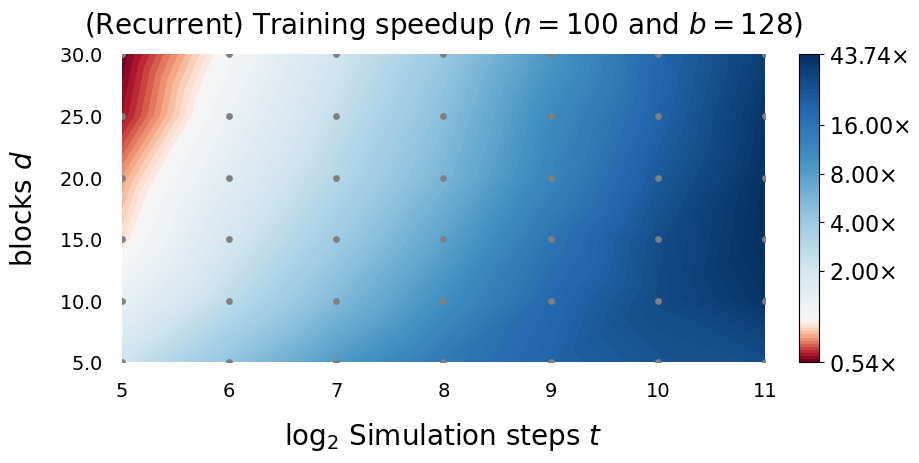

In [31]:
def plot_recurrent_dvst(fig, spec):
    batch = 128
    speedups_df = benchmark_dvst_query.get_speedups(apply_mean_time=True, batch=batch, heterogeneous_beta=True, beta_requires_grad=False, recurrent=True)
    plot_2d_speedups(fig, spec, speedups_df, "$\\log_2$ Simulation steps $t$", "blocks $d$", f"(Recurrent) Training speedup ($n=100$ and $b={batch}$)")
    
fig = plt.figure(figsize=(9, 4))
fig_spec = gridspec.GridSpec(1, 1)
plot_recurrent_dvst(fig, fig_spec[0, 0])

plt.savefig(f"{root}/figures/app_figure6.pdf", dpi=300, bbox_inches="tight")

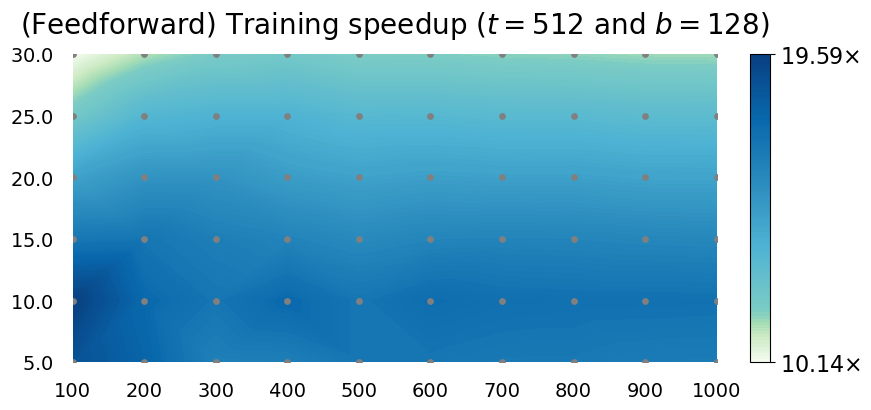

In [14]:
def plot_feedforward_dvsn(fig, spec):
    batch = 128
    speedups_df = benchmark_dvsn_query.get_speedups(apply_mean_time=True, batch=batch, heterogeneous_beta=True, beta_requires_grad=False, recurrent=False)
    plot_2d_speedups(fig, spec, speedups_df, "", "", f"(Feedforward) Training speedup ($t=512$ and $b={batch}$)", log_x=False, cmap=plt.cm.GnBu, midpoint=3.5)
    
fig = plt.figure(figsize=(9, 4))
fig_spec = gridspec.GridSpec(1, 1)
plot_feedforward_dvsn(fig, fig_spec[0, 0])

plt.savefig(f"{root}/figures/app_figure9.pdf", dpi=300, bbox_inches="tight")

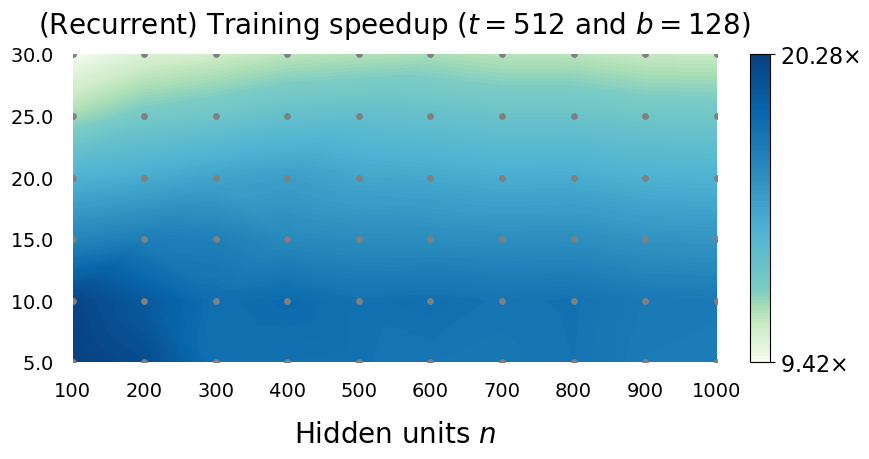

In [15]:
def plot_recurrent_dvsn(fig, spec):
    batch = 128
    speedups_df = benchmark_dvsn_query.get_speedups(apply_mean_time=True, batch=batch, heterogeneous_beta=True, beta_requires_grad=False, recurrent=True)
    plot_2d_speedups(fig, spec, speedups_df, "Hidden units $n$", "", f"(Recurrent) Training speedup ($t=512$ and $b={batch}$)", log_x=False, cmap=plt.cm.GnBu, midpoint=3.5)
    
fig = plt.figure(figsize=(9, 4))
fig_spec = gridspec.GridSpec(1, 1)
plot_recurrent_dvsn(fig, fig_spec[0, 0])

plt.savefig(f"{root}/figures/app_figure12.pdf", dpi=300, bbox_inches="tight")

## Omnipotent plot

In [16]:
def plot_letter(letter, fig_spec, scale=1):
    shift = 0.2
    fontsize = 25
    ax = plt.Subplot(fig, fig_spec)
    ax.text(-shift/scale, 1.27, letter, horizontalalignment="right", verticalalignment="top", transform=ax.transData, fontweight="bold", fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.add_subplot(ax)

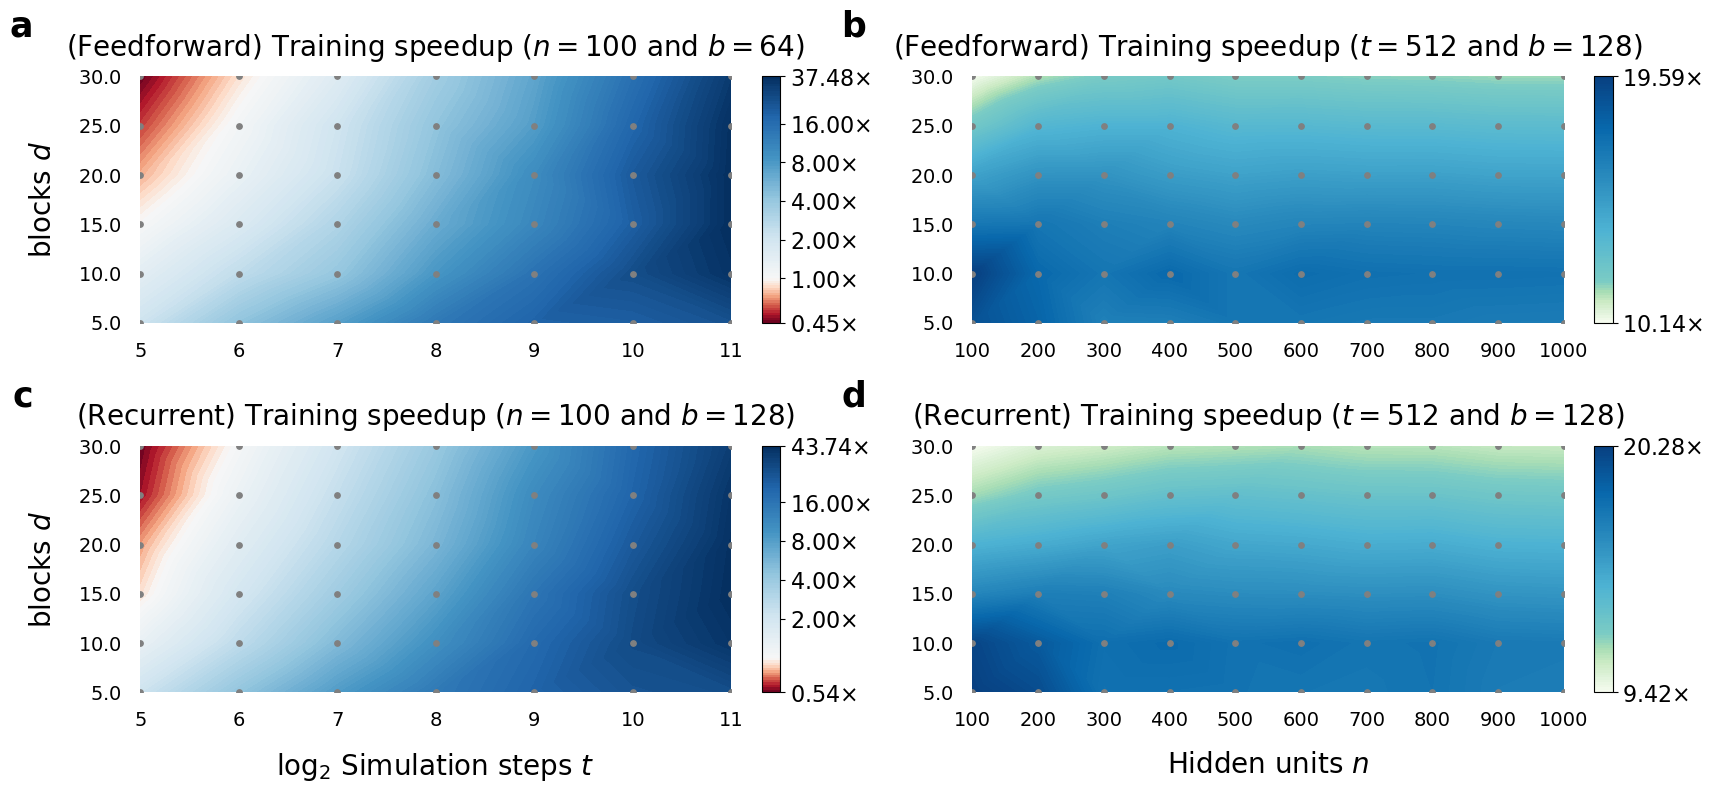

In [17]:
space = 0.65
fig = plt.figure(figsize=(19, 8))
fig_spec = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.3)

# Plot top row
plot_feedforward_dvst(fig, fig_spec[0, 0])
plot_feedforward_dvsn(fig, fig_spec[0, 1])
plot_recurrent_dvst(fig, fig_spec[1, 0])
plot_recurrent_dvsn(fig, fig_spec[1, 1])

scale = 1.2
plot_letter("a", fig_spec[0, 0], scale=scale)
plot_letter("b", fig_spec[0, 1], scale=scale)
plot_letter("c", fig_spec[1, 0], scale=scale)
plot_letter("d", fig_spec[1, 1], scale=scale)

plt.savefig(f"{root}/figures/figure3.pdf", dpi=300, bbox_inches="tight")